In [137]:
import tensorflow as tf
import keras as ks
from keras import models
from keras import metrics
import pandas as pd
import numpy as np
import sklearn
from sklearn import model_selection

In [138]:
rawdata=pd.read_csv('/content/TSLA.csv').round(3)

In [139]:
rawdata=rawdata.dropna()
rawdata

,Date,Open,High,Low,Close,Adj Close,Volume,Interest,Currency,Inflation,Day,Month
0,2010-06-30,1.719,2.028,1.553,1.589,1.589,257806500.0,3.20,0.678,1.1,30,6
1,2010-07-01,1.667,1.728,1.351,1.464,1.464,123282000.0,3.01,0.654,1.2,1,7
2,2010-07-02,1.533,1.540,1.247,1.280,1.280,77097000.0,3.01,0.654,1.2,2,7
3,2010-07-06,1.333,1.333,1.055,1.074,1.074,103003500.0,3.01,0.654,1.2,6,7
4,2010-07-07,1.093,1.109,0.999,1.053,1.053,103825500.0,3.01,0.654,1.2,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...
3206,2023-03-27,194.420,197.390,189.940,191.810,191.810,120851600.0,3.66,0.824,5.0,27,3
3207,2023-03-28,192.000,192.350,185.430,189.190,189.190,98654600.0,3.66,0.824,5.0,28,3
3208,2023-03-29,193.130,195.290,189.440,193.880,193.880,123660000.0,3.66,0.824,5.0,29,3
3209,2023-03-30,195.580,197.330,194.420,195.280,195.280,110252200.0,3.66,0.824,5.0,30,3


In [140]:
data=pd.DataFrame()
data['Open']=rawdata['Open'].astype(np.float64)
data['High']=rawdata['High'].astype(np.float64)
data['Low']=rawdata['Low'].astype(np.float64)
data['Close']=rawdata['Close'].astype(np.float64)
data['Currency']=rawdata['Currency'].astype(np.float64)
data['Interest']=rawdata['Interest'].astype(np.float64)
data['Inflation']=rawdata['Inflation'].astype(np.float64)
data['Day']=rawdata['Day'].astype(np.int64)
data['Month']=rawdata['Month'].astype(np.int64)
data.head()

,Open,High,Low,Close,Currency,Interest,Inflation,Day,Month
0,1.719,2.028,1.553,1.589,0.678,3.20,1.1,30,6
1,1.667,1.728,1.351,1.464,0.654,3.01,1.2,1,7
2,1.533,1.540,1.247,1.280,0.654,3.01,1.2,2,7
3,1.333,1.333,1.055,1.074,0.654,3.01,1.2,6,7
4,1.093,1.109,0.999,1.053,0.654,3.01,1.2,7,7


In [141]:
train=data.iloc[:int(0.8*len(data))]
test=data.iloc[int(0.8*len(data)):]

In [142]:
def sliding_window(stockdata):
  window_size=7
  windowed_data=[]
  for i in range(len(stockdata)-window_size):
      window=stockdata[i:i+window_size]
      windowed_data.append(window)
  return np.array(windowed_data)

In [143]:
#run to keep batches ordered
X=sliding_window(train)
Y=train['Close'][7:]
TestingX=sliding_window(test)
TestingY=test['Close'][7:]

In [144]:
x_train,x_test,y_train,y_test=model_selection.train_test_split(X,Y,test_size=0.2)

In [145]:
metric=[metrics.RootMeanSquaredError(),metrics.MeanAbsoluteError(),metrics.MeanAbsolutePercentageError(),metrics.MeanSquaredLogarithmicError()]
def modelbuild():
    model = models.Sequential()
    model.add(ks.layers.LSTM(128, return_sequences=True,activation='relu', input_shape=(7,9),dropout=0.1,recurrent_dropout=0.1))
    model.add(ks.layers.SimpleRNN(32,activation='relu'))
    model.add(ks.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=metric)
    return model

In [146]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 7, 128)            70656     
                                                                 
 simple_rnn_23 (SimpleRNN)   (None, 32)                5152      
                                                                 
 dense_26 (Dense)            (None, 1)                 33        
                                                                 
Total params: 75,841
Trainable params: 75,841
Non-trainable params: 0
_________________________________________________________________


In [147]:
model=modelbuild()
stop = ks.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test),callbacks=[stop])
#history = model.fit(x_train, y_train, epochs=10,validation_data=(x_test, y_test))

test_loss, rmse, mae, mape, msle = model.evaluate(x_test, y_test, verbose=2)

print('\nMean Squared Error: ', test_loss)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Mean Absolute Percentage Error: ', mape)
print('Mean Squared Logarithmic Error: ', msle)

Epoch 1/10
64/64 [==============================] - 7s 41ms/step - loss: 53.8042 - root_mean_squared_error: 7.3351 - mean_absolute_error: 3.3832 - mean_absolute_percentage_error: 29.0579 - mean_squared_logarithmic_error: 0.2799 - val_loss: 4.3825 - val_root_mean_squared_error: 2.0934 - val_mean_absolute_error: 1.1910 - val_mean_absolute_percentage_error: 9.1096 - val_mean_squared_logarithmic_error: 0.0093
Epoch 2/10
64/64 [==============================] - 2s 29ms/step - loss: 18.1615 - root_mean_squared_error: 4.2616 - mean_absolute_error: 1.8731 - mean_absolute_percentage_error: 13.8971 - mean_squared_logarithmic_error: 0.0220 - val_loss: 3.5641 - val_root_mean_squared_error: 1.8879 - val_mean_absolute_error: 0.8894 - val_mean_absolute_percentage_error: 8.2543 - val_mean_squared_logarithmic_error: 0.0093
Epoch 3/10
64/64 [==============================] - 2s 29ms/step - loss: 12.2087 - root_mean_squared_error: 3.4941 - mean_absolute_error: 1.6623 - mean_absolute_percentage_error: 12.

In [148]:
test_loss, rmse, mae, mape, msle = model.evaluate(TestingX,TestingY,verbose=1)
print('\nMean Squared Error: ', test_loss)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Mean Absolute Percentage Error: ', mape)
print('Mean Squared Logarithmic Error: ', msle)
print("Want to save model?")
c=input()
if c=='y':
  ks.Model.save(model,'/content/models')

20/20 [==============================] - 0s 11ms/step - loss: 264.2437 - root_mean_squared_error: 16.2556 - mean_absolute_error: 12.2616 - mean_absolute_percentage_error: 5.0515 - mean_squared_logarithmic_error: 0.0042

Mean Squared Error:  264.24371337890625
Root Mean Squared Error:  16.25557518005371
Mean Absolute Error:  12.261564254760742
Mean Absolute Percentage Error:  5.0514726638793945
Mean Squared Logarithmic Error:  0.004206480458378792
Want to save model?
y


101/101 [==============================] - 1s 8ms/step


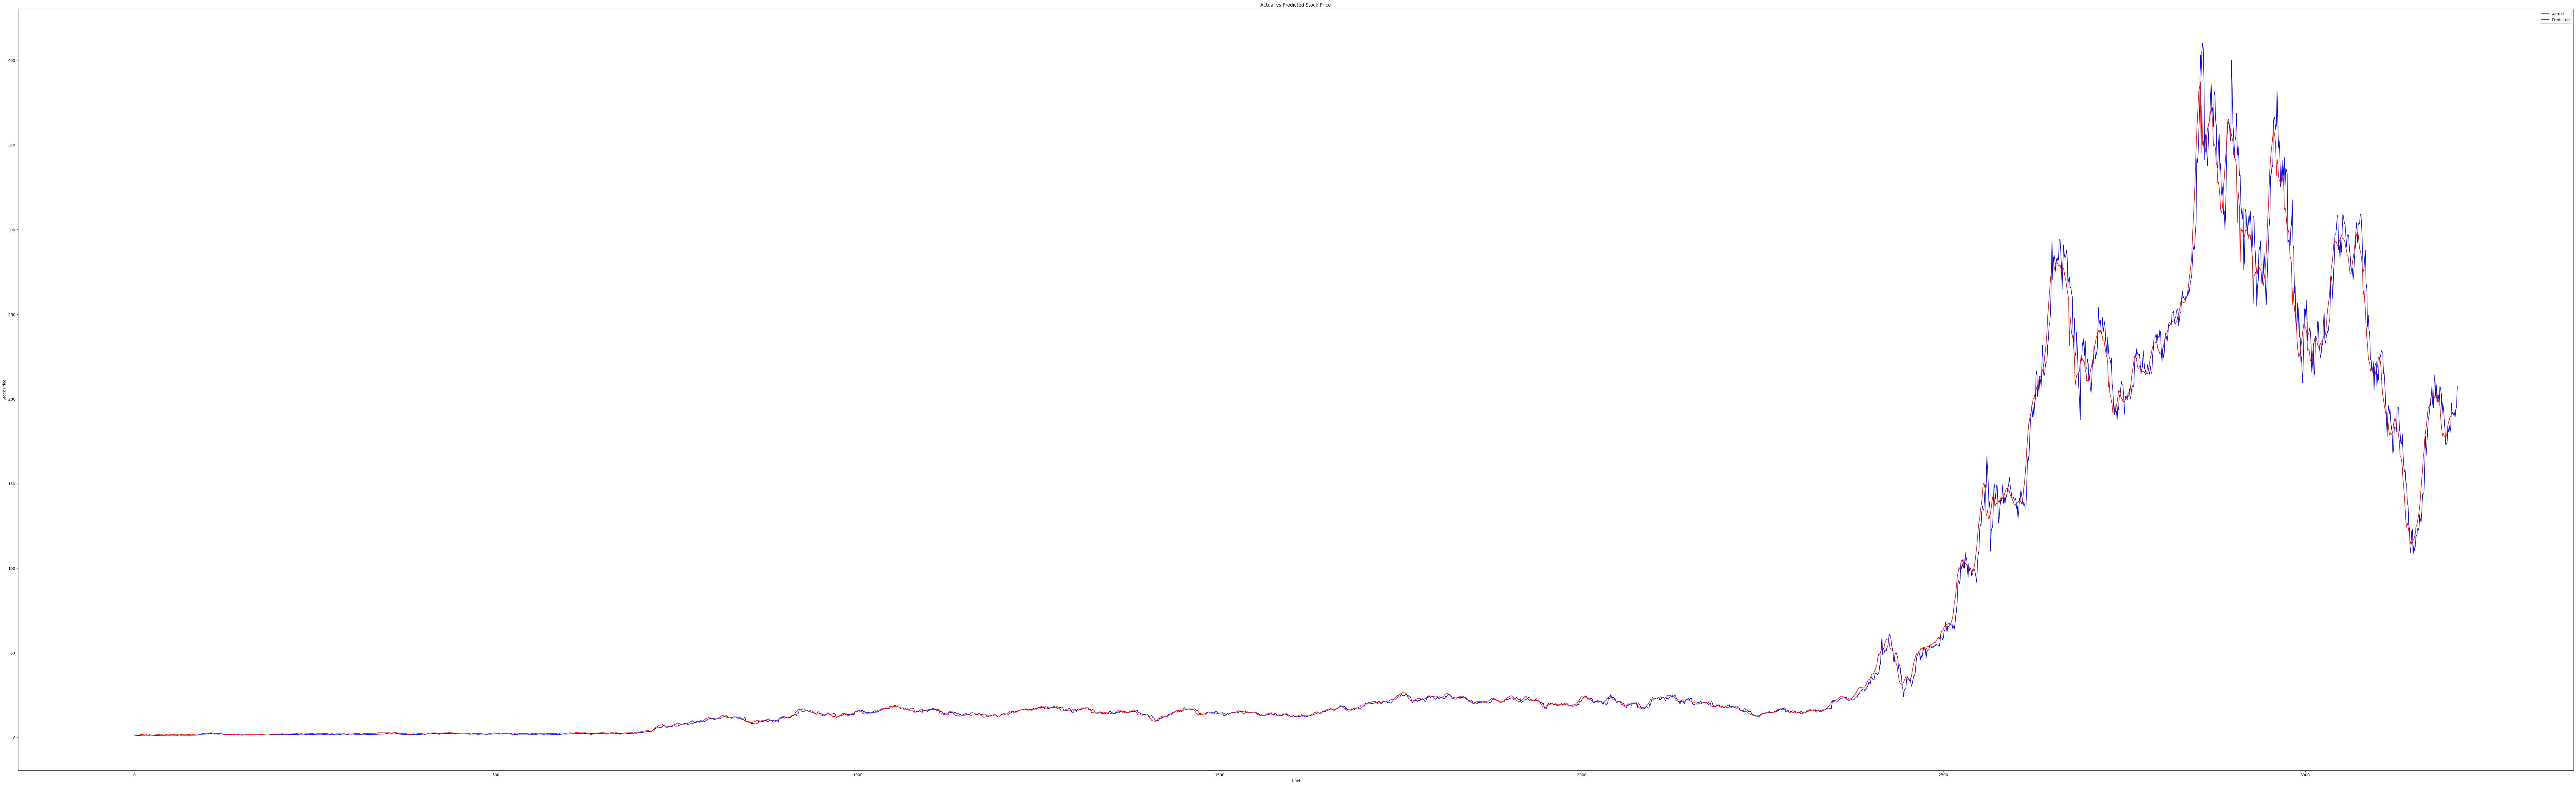

In [149]:
predicted_prices=model.predict(sliding_window(data))
actual_prices=data['Close']
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(120,36))
plt.plot(actual_prices, color='blue', label='Actual')
plt.plot(predicted_prices, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Price')
plt.legend()
plt.show()